In [1]:
import numpy as np
import random
from math import *
import time

import copy

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer_out = torch.nn.Linear(layer_width, 1)
    def forward(self,x):
        output = self.layer_out(x)
        return output

In [4]:
dimension = 1

In [5]:
input_width,layer_width = dimension, 1

In [6]:
net = Net(input_width,layer_width)

In [7]:
# defination of exact solution
def u_ex(x):     
    u_temp = 2*x**3 - x**2 - x
    return u_temp.reshape([x.size()[0], 1])

In [8]:
# defination of f(x)
def f(x):
    f_temp = -(12*x - 2)
    return f_temp.reshape([x.size()[0],1])

In [9]:
# generate points by random
def generate_sample(data_size):
    sample_temp = torch.rand(data_size, dimension)
    return sample_temp

In [10]:
def model(x):
    x_temp = x
    D_x_0 = torch.prod(x_temp, axis = 1).reshape([x.size()[0], 1]) 
    D_x_1 = torch.prod(1.0 - x_temp, axis = 1).reshape([x.size()[0], 1]) 
    model_u_temp = D_x_0 * D_x_1 * net(x)
    return model_u_temp.reshape([x.size()[0], 1])

In [11]:
# loss function to DRM by auto differential
def loss_function(x):
#     x = generate_sample(data_size).cuda()
#     x.requires_grad = True
    u_hat = model(x)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x, grad_outputs = torch.ones(u_hat.shape), create_graph = True)
    grad_u_sq = ((grad_u_hat[0]**2).sum(1)).reshape([len(grad_u_hat[0]), 1])
    part = torch.sum(0.5 * grad_u_sq  - f(x) * u_hat)  / len(x)
    return part

In [12]:
data_size = 10000
x = generate_sample(data_size)
x.requires_grad = True

In [13]:
def get_weights(net):
    """ Extract parameters from net, and return a list of tensors"""
    return [p.data for p in net.parameters()]

In [14]:
def set_weights(net, weights, directions=None, step=None):
    """
        Overwrite the network's weights with a specified list of tensors
        or change weights along directions with a step size.
    """
    if directions is None:
        # You cannot specify a step length without a direction.
        for (p, w) in zip(net.parameters(), weights):
            p.data.copy_(w.type(type(p.data)))
    else:
        assert step is not None, 'If a direction is specified then step must be specified as well'

        if len(directions) == 2:
            dx = directions[0]
            dy = directions[1]
            changes = [d0*step[0] + d1*step[1] for (d0, d1) in zip(dx, dy)]
        else:
            changes = [d*step for d in directions[0]]

        for (p, w, d) in zip(net.parameters(), weights, changes):
            p.data = w + torch.Tensor(d).type(type(w))

In [15]:
def set_states(net, states, directions=None, step=None):
    """
        Overwrite the network's state_dict or change it along directions with a step size.
    """
    if directions is None:
        net.load_state_dict(states)
    else:
        assert step is not None, 'If direction is provided then the step must be specified as well'
        if len(directions) == 2:
            dx = directions[0]
            dy = directions[1]
            changes = [d0*step[0] + d1*step[1] for (d0, d1) in zip(dx, dy)]
        else:
            changes = [d*step for d in directions[0]]

        new_states = copy.deepcopy(states)
        assert (len(new_states) == len(changes))
        for (k, v), d in zip(new_states.items(), changes):
            d = torch.tensor(d)
            v.add_(d.type(v.type()))

        net.load_state_dict(new_states)

In [16]:
def get_random_weights(weights):
    """
        Produce a random direction that is a list of random Gaussian tensors
        with the same shape as the network's weights, so one direction entry per weight.
    """
    return [torch.randn(w.size()) for w in weights]

In [17]:
def get_random_states(states):
    """
        Produce a random direction that is a list of random Gaussian tensors
        with the same shape as the network's state_dict(), so one direction entry
        per weight, including BN's running_mean/var.
    """
    return [torch.randn(w.size()) for k, w in states.items()]

In [18]:
def get_diff_weights(weights, weights2):
    """ Produce a direction from 'weights' to 'weights2'."""
    return [w2 - w for (w, w2) in zip(weights, weights2)]

In [19]:
def get_diff_states(states, states2):
    """ Produce a direction from 'states' to 'states2'."""
    return [v2 - v for (k, v), (k2, v2) in zip(states.items(), states2.items())]

In [20]:
def normalize_direction(direction, weights, norm='filter'):
    """
        Rescale the direction so that it has similar norm as their corresponding
        model in different levels.
        Args:
          direction: a variables of the random direction for one layer
          weights: a variable of the original model for one layer
          norm: normalization method, 'filter' | 'layer' | 'weight'
    """
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each
        # filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights):
            d.mul_(w.norm()/(d.norm() + 1e-10))
    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has
        # the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())
    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same
        # scale as the corresponding weight.
        direction.mul_(weights)
    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction
        # has the unit norm.
        for d in direction:
            d.div_(d.norm() + 1e-10)
    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has
        # the unit norm.
        direction.div_(direction.norm())

In [21]:
def normalize_directions_for_weights(direction, weights, norm='filter', ignore='biasbn'):
    """
        The normalization scales the direction entries according to the entries of weights.
    """
    assert(len(direction) == len(weights))
    for d, w in zip(direction, weights):
        if d.dim() <= 1:
            if ignore == 'biasbn':
                d.fill_(0) # ignore directions for weights with 1 dimension
            else:
                d.copy_(w) # keep directions for weights/bias that are only 1 per node
        else:
            normalize_direction(d, w, norm)

In [22]:
def normalize_directions_for_states(direction, states, norm='filter', ignore='ignore'):
    assert(len(direction) == len(states))
    for d, (k, w) in zip(direction, states.items()):
        if d.dim() <= 1:
            if ignore == 'biasbn':
                d.fill_(0) # ignore directions for weights with 1 dimension
            else:
                d.copy_(w) # keep directions for weights/bias that are only 1 per node
        else:
            normalize_direction(d, w, norm)

In [23]:
def ignore_biasbn(directions):
    """ Set bias and bn parameters in directions to zero """
    for d in directions:
        if d.dim() <= 1:
            d.fill_(0)

In [24]:
def create_random_direction(net, dir_type='weights', ignore='biasbn', norm='filter'):
    """
        Setup a random (normalized) direction with the same dimension as
        the weights or states.
        Args:
          net: the given trained model
          dir_type: 'weights' or 'states', type of directions.
          ignore: 'biasbn', ignore biases and BN parameters.
          norm: direction normalization method, including
                'filter" | 'layer' | 'weight' | 'dlayer' | 'dfilter'
        Returns:
          direction: a random direction with the same dimension as weights or states.
    """

    # random direction
    if dir_type == 'weights':
        weights = get_weights(net) # a list of parameters.
        direction = get_random_weights(weights)
        normalize_directions_for_weights(direction, weights, norm, ignore)
    elif dir_type == 'states':
        states = net.state_dict() # a dict of parameters, including BN's running mean/var.
        direction = get_random_states(states)
        normalize_directions_for_states(direction, states, norm, ignore)

    return direction

In [25]:
def tvd(m, l_i):
    
    # load model parameters
    pretrained_dict = torch.load('net_params_DRM.pkl')
    
    # get state_dict
    net_state_dict = net.state_dict()

    # remove keys that does not belong to net_state_dict
    pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if k in net_state_dict}

    # update dict
    net_state_dict.update(pretrained_dict_1)

    # set new dict back to net
    net.load_state_dict(net_state_dict)
    
    weights_temp = get_weights(net)
    states_temp = net.state_dict()
    
    step_size = 2 * l_i / m  
    grid = np.arange(-l_i, l_i + step_size, step_size)
    num_direction = 1
    loss_matrix = torch.zeros((num_direction, len(grid)))

    for temp in range(num_direction):
        weights = weights_temp
        states = states_temp
        direction_temp = create_random_direction(net, dir_type='weights', ignore='biasbn', norm='filter')
        normalize_directions_for_states(direction_temp, states, norm='filter', ignore='ignore')
        directions = [direction_temp]

        for dx in grid:
            itemindex_1 = np.argwhere(grid == dx)
            step = dx

            set_states(net, states, directions, step)
            loss_temp = loss_function(x)
            loss_matrix[temp, itemindex_1[0]] = loss_temp
            
            # clear memory
            torch.cuda.empty_cache()

            # get state_dict
            net_state_dict = net.state_dict()
            # remove keys that does not belong to net_state_dict
            pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if k in net_state_dict}
            # update dict
            net_state_dict.update(pretrained_dict_1)
            # set new dict back to net
            net.load_state_dict(net_state_dict)
            weights_temp = get_weights(net)
            states_temp = net.state_dict()

    interval_length = grid[-1] - grid[0]
    TVD = 0.0
    for temp in range(num_direction):
        for index in range(loss_matrix.size()[1] - 1):
            TVD = TVD + np.abs(float(loss_matrix[temp, index] - loss_matrix[temp, index + 1]))
    Max = np.max(loss_matrix.detach().numpy())
    Min = np.min(loss_matrix.detach().numpy())

    TVD = TVD / interval_length / num_direction / (Max - Min)

    return TVD, Max, Min

In [26]:
M = 50
m = 50
l_i = 1.0

TVD_DGM = 0.0

time_start = time.time()

Max = []
Min = []
Result = []

for count in range(M):
    TVD_temp, Max_temp, Min_temp = tvd(m, l_i)
#     print(Max_temp, Min_temp)
    Max.append(Max_temp)
    Min.append(Min_temp)
    Result.append(TVD_temp)
    print('Current direction TVD of DRM is: ', TVD_temp)
    TVD_DGM = TVD_DGM + TVD_temp
    print((count + 1) / M * 100, '% finished.')

# print('Max of all is: ', np.max(Max))
# print('Min of all is: ', np.min(Min))

TVD_DGM = TVD_DGM / M 
print('All directions average TVD of DRM is: ', TVD_DGM)

print('Variance TVD of DRM is: ', np.sqrt(np.var(Result, ddof = 1)))

time_end = time.time()
print('Total time costs: ', time_end - time_start, 'seconds')

/home/keke/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Current direction TVD of DRM is:  0.9825120093614648
2.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
4.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
6.0 % finished.
Current direction TVD of DRM is:  0.9959748008404222
8.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
10.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
12.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
14.000000000000002 % finished.
Current direction TVD of DRM is:  0.9825120093614648
16.0 % finished.
Current direction TVD of DRM is:  0.9959748008404222
18.0 % finished.
Current direction TVD of DRM is:  0.9959748008404222
20.0 % finished.
Current direction TVD of DRM is:  0.9959748008404222
22.0 % finished.
Current direction TVD of DRM is:  0.9959748008404222
24.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
26.0 % finished.
Current direction TVD of DRM is:  0.9825120093614648
28.000000000000004 % finish

In [27]:
import matplotlib.pylab as plt 
import matplotlib.pyplot as mp
import numpy as np
plt.style.use("seaborn-dark") # print(plt.style.available)
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

In [28]:
dirc = [i + 1 for i in range(len(Result))]

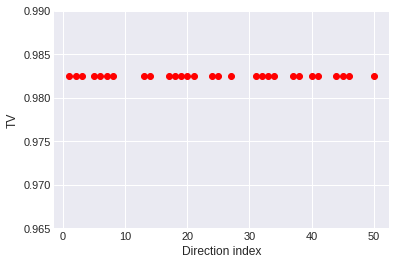

In [29]:
import matplotlib.pylab as plt 
import matplotlib.pyplot as mp
import numpy as np

plt.style.use("seaborn-dark")
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.set_ylim(0.965, 0.99)

plt.scatter(dirc, Result, c = 'red')
plt.xlabel('Direction index', size = 12)
plt.ylabel('TV', size = 12)
plt.grid(True)
# plt.savefig("Relative_error.eps", dpi = 120)
plt.show()

In [30]:
np.save('DRM.npy', Result)